# Figure list for general exam report


In [3]:
dir = "/nobackup1/hdrake/pgcm/"
using PyPlot
using Interpolations

## Fig 2

PyCall.PyDict(matplotlib["rcParams"])["font.size"]=14;

10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 

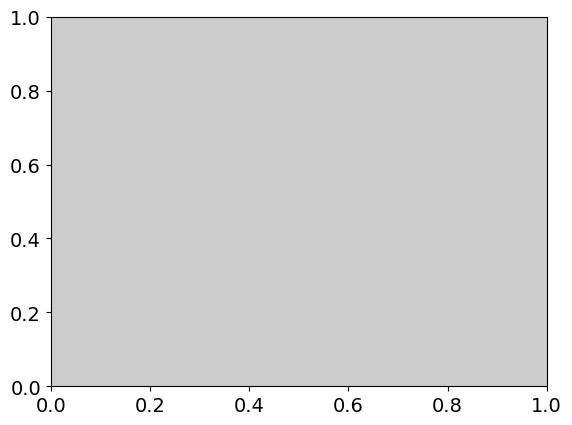

100%, 

In [4]:
dir = "/nobackup1/hdrake/pgcm/"

expname = "src_kappa-bottom_ridge-0.8_a-0.0"

include(string(dir,expname,"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

ax = gca();
ax["set_facecolor"]((0.8,0.8,0.8));

div_cmap=get_cmap("RdBu_r");
div_cmap["set_bad"](color="black");

cmap=get_cmap("viridis");
PyCall.PyDict(matplotlib["rcParams"])["contour.negative_linestyle"] = "solid";

ex = 1

## Figure settings
cmap=get_cmap("RdBu_r")
PyCall.PyDict(matplotlib["rcParams"])["contour.negative_linestyle"] = "solid"

## Model Parameters
r = 0.1; # friction coefficient
a = 0.2; # aspect ratio (?)

for nIter = [40000*50]
    ## Scales
    N = sqrt(2)*1.e-3
    H = 4000
    B = 2.e-11
    L = 6e6
    T = nIter/40000.

    #------------------------  Load  Model data  ------------------------------

    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

    # Restoring
    Dr = -m.cc.*(s.bc-m.bic)

    # Advective fluxes
    # get velocities
    Ux, Uy, Us = velocities(m,s.bc)
    # calculate advective fluxes
    hFx = m.hfx.*Ux.*ixcf(m,s.bc)
    hFy = m.hfy.*Uy.*iycf(m,s.bc)
    hFs = m.hc.*Us.*iscf(m,s.bc)

    # Advective flux divergence
    Du = zeros(s.bc)
    Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
    Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
    Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Advective flux divergences
    Dux = zeros(s.bc)
    Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

    Duy = zeros(s.bc)
    Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

    Dus = zeros(s.bc)
    Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Buoyancy tendency 
    s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
    dbdt = (s1.bc-s.bc)/(m.dt*4000.)

    # Diagnose diffusive flux divergence from other terms
    Dkc = dbdt - (Du + Dr)

    #------------------------  1D solution  ------------------------------
    dt = 5.e-3

    # geometry
    tht = -atan.(m.hxc)
    y = m.yc

    # numerical parametersq
    n = 150
    h = 1.0

    # stratification
    N0 = dscc(m,m.bic,0)./m.hc
    gam = N0

    #grid
    dz = h/n
    z = dz/2:dz:h-dz/2
    zf = 0:dz:h

    # height above bottom
    zc = ((m.sc.*m.hc).+m.hc);

    # slope normal distance from bottom
    zcp = zc.*cos.(tht)

    bc = zeros(s.bc)
    kc = zeros(s.bc)

    # RHS of the buoyancy equation (excl. diffusion)
    rhs(b,j,i) = -r*gam[1,j,i]*tan(tht[1,j,i]).^2./(m.yc[j].^2+r^2).*b

    # timestepping function (k1 advection and implicit diffusion)
    function timestep(b, D, rem, j, i)
        k1 = rhs(b,j,i)
        b += dt*k1
        b = D\(b.+rem)
        return b
    end

    for j=1:size(s.bc,2)
        if (j%20)==0; print(Int(round(j/size(s.bc,2)*100)),"%, "); end
        if (m.yc[j]<0.); continue; end
        for i=1:size(s.bc,3)

            # geometry
            phi = sqrt(cos(tht[1,j,i])^2+a^2*sin(tht[1,j,i])^2)

            del = 0.1
            kridge = 0.1
            kbg = 5.e-4
            kslope = 5.e-3

            x0w = 0.4
            x0e = 0.6
            y0s = -0.5
            del0 = 0.1
            fac = 1.
            if m.xc[i]<x0w; fac = exp(-((m.xc[i]-x0w)/(del0))^2); end;
            if m.xc[i]>x0e; fac = exp(-((m.xc[i]-x0e)/(del0))^2); end;
            if m.yc[j]<y0s; fac *= exp(-((m.yc[j]-y0s)/(del0))^2); end;
            fac = (kslope/kridge)+(1-(kslope/kridge))*fac
            kap = kbg+(kridge*exp.(-(zf/cos(tht[1,j,i])/del))*fac)

            # diffusion matrix for b
            d = ones(n)
            o = dt*phi^2*kap[2:n]/dz^2
            d[1:n-1] += o
            d[2:n] += o
            D = spdiagm((-o,d,-o),(-1,0,1))
            D = factorize(D)
            rem = dt*(kap[2:n+1]-kap[1:n])*gam[1,j,i]*cos(tht[1,j,i])/dz # What do you call this?
            rem[1] += dt*kap[1]*gam[1,j,i]*cos(tht[1,j,i])/dz #BC

            # initial conditions
            b = zeros(n)
            k = 0.5*(kap[2:end]+kap[1:end-1])

            for ts = 1:Int(round(T/dt))
                b = timestep(b, D, rem, j, i)
            end

            # Numerical solution, interpolated
            itp = interpolate((z,),b,Gridded(Linear()))
            bc[:,j,i] = itp[zcp[:,j,i]]

            itp = interpolate((z,),k,Gridded(Linear()))
            kc[:,j,i] = itp[zcp[:,j,i]]
        end
    end
    b0 = m.bic
    bc += b0


    # 1D prediction velocities in rotated coordinates
    uxr = r.*tan.(tht).^2./((r^2.+m.yc.^2).*sin.(tht)).*(bc-b0)
    uyr = (-m.yc.*cos.(tht)/r).*uxr
    uzr = uxr*0.
    uxr[(tht.*ones(uxr)).<=0] = -uxr[(tht.*ones(uxr)).<=0];

    # PGCM
    uxcr = uxc.*cos.(tht)+uzc.*sin.(tht);
    uxcr[(tht.*ones(uxcr)).<=0] = -uxcr[(tht.*ones(uxcr)).<=0];
    uzcr = uzc.*cos.(tht)-uxc.*sin.(tht);

    ## Calculate diffusive flux divergence 
    # explicit fluxes from PGCM
    hFx = -m.a.^2.*m.kfx.*(m.hfx.*dxcf(m,bc).-m.sc.*m.hxfx.*dscc(m,ixcf(m,bc),0))
    hFy = -m.a.^2.*m.kfy.*(m.hfy.*dycf(m,bc).-m.sc.*m.hyfy.*dscc(m,iycf(m,bc),0))
    hFs = m.a.^2.*m.kfs.*m.sf.*(m.hxc.*dxcc(m,iscf(m,bc))+m.hyc.*dycc(m,iscf(m,bc)))

    # add in explicit representation of implicit sigma component of sigma flux
    hFs_explicit = -m.kfs.*(1.+m.a.^2.*m.sf.^2.*(m.hxc.^2.+m.hyc.^2)).*iscf(m,dscc(m,bc,0))./m.hc
    hFs += hFs_explicit;

    # Diffusive flux divergence
    Dk = zeros(s.bc)
    Dk[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx);
    Dk[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx);
    Dk[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy);
    Dk[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy);
    Dk[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds);
    Dk[2:m.ns,:,:] += hFs./(m.hc*m.ds);
    Dk[18:end,:,:] = 0.

    file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "w")
    write(file, "bc", bc)
    write(file, "Dk", Dk)
    write(file, "dt", dt)
    write(file, "n", n)
    write(file, "h", h)
    close(file)

end